# Introduction to Spatial Analysis: Part 2

*Data Science Africa 2019, Addis Ababa<br>
Instructor: John Quinn*

In this notebook, we'll look at an example of analysis with spatial data: predicting where deforestation is likely to occur in East Africa. Using data about the areas in which trees were cut down in previous years, as well as some covariates such as where there are roads, we will produce a map of predicted probability of deforestation. 

### Data sources

**Global Forest Change, University of Maryland**<br>
This data is derived from satellite imagery, from which the amount of forest cover each year everywhere on the planet is calculated.<br>
https://earthenginepartners.appspot.com/science-2013-global-forest/download_v1.2.html

**Humanitarian OpenStreetMap**<br>
OpenStreetMap data is manually entered by volunteers. Here we specifically use just the data on the locations of roads.<br>
https://data.humdata.org/dataset/hotosm_ken_roads

**World Database on Protected Areas**<br>
Official dataset complied from the governments of each country, with the specific coordinates of nature reserves etc<br>
https://www.protectedplanet.net/

In [1]:
from sklearn import neighbors, ensemble, metrics
import scipy
import scipy.ndimage
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Read in the data, and specify some helper functions.

In this example we use arrays to hold the spatial information. They are just like images, except that each "pixel" in the grid has a specific location. The grid we use covers Kenya, Uganda and Tanzania.

After running the code below, we get:

- A function to get the amount of tree cover for any year between 2000 and 2017, at any position in the grid, `treecover_at_year()`.
- A function to get the amount of deforestation for any year between 2000 and 2016, `loss_in_year()`.
- Functions for converting between the position of a cell in the array to longitude/latitude.
- An array called `roads`, with values 0 or 1 denoting whether there is a road at the corresponding location.
- An array called `protectedareas`, with values 0 or 1 denoting whether the corresponding location is part of a nature reserve or other protected area.
- A mask array called `extent` with values of 1 for every location that is inside the boundary of Uganda, Kenya and Tanzania, and values of 0 otherwise.

In [2]:
with np.load('data/ke_tz_ug_spatialdata.npz') as datafile:
    roads = datafile['roads']
    extent = datafile['extent']
    protectedareas = datafile['protectedareas']
    lossyear = datafile['lossyear']
    treecover2000 = datafile['treecover']
    geotransform = datafile['geotransform']
    
def treecover_at_year(year):
    '''Return the tree cover for each pixel at the given year (2000-2017).
    Year is specified as an int between 0 and 17'''
    
    if year==0:
        return treecover2000
    cover = treecover2000.copy()
    cover[np.where(np.logical_and(lossyear>0, lossyear<=year))] = 0
    return cover

def loss_in_year(year):
    '''Return the pixels corresponding to deforested areas in the given year (2001-2016).
    Year is specified as an int between 1 and 16'''
    
    loss = lossyear==year
    return loss.astype('float') 

def lonlat2XY(pt):
    '''Convert from a (longitude,latitude) tuple to (x,y) position in pixels.'''
    x = int((pt[0] - geotransform[0])/geotransform[1])
    y = int((pt[1] - geotransform[3])/geotransform[5])
    return np.array([x,y])

def XY2lonlat_sgl(pt):
    '''Convert from an (x,y) position in pixels to (longitude,latitude).'''
    xoff, a, b, yoff, d, e = geotransform
    lon = a * pt[0] + b * pt[1] + xoff
    lat = d * pt[0] + e * pt[1] + yoff
    return np.array([lon, lat])

def XY2lonlat(pt):
    '''Convert from x,y image coordinates to longitude,latitude.
    pt should be Nx2 array of x,y positions'''
    xoff, a, b, yoff, d, e = geotransform
    lon = a * pt[:,0] + b * pt[:,1] + xoff
    lat = d * pt[:,0] + e * pt[:,1] + yoff
    return np.array([lon, lat]).transpose()

Have a look at what the forest cover levels were in the year 2000.

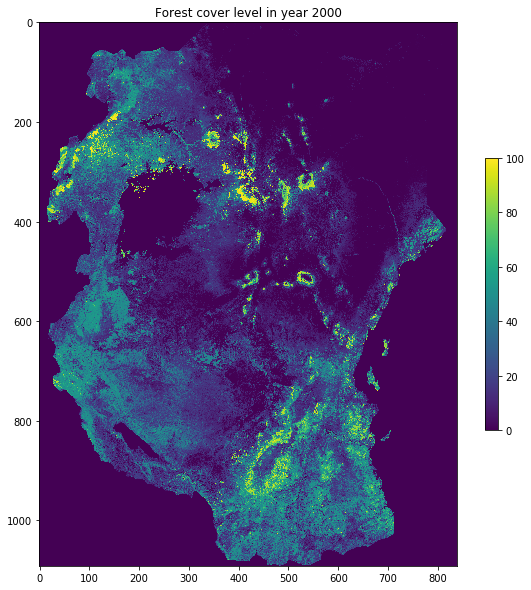

In [3]:
year = 2000
imshow(treecover_at_year(year-2000))
title('Forest cover level in year %d' % (year))
gcf().set_size_inches(10,10)
colorbar(shrink=0.5)

Now have a look at an example of the deforestation for a particular year. This is more difficult to see because the deforested areas are spread out in points.

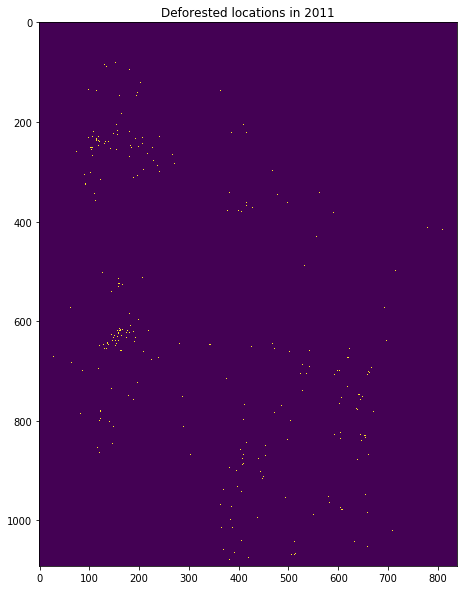

In [4]:
year = 2011
imshow(loss_in_year(year-2000))
title('Deforested locations in %d' % (year))
gcf().set_size_inches(10,10)

### Calculating the density of deforestation

We can see above that there are some locations where points of deforestation are concentrated together, and other areas where there doesn't seem to be much deforestation. What we need to do next is calculate the density from these points. That is, we want to get some estimate of how much deforestation there is in the general area. Here we do it by Gaussian filtering.

Try changing the filter scale below. What do you notice as you change it to be bigger or smaller?

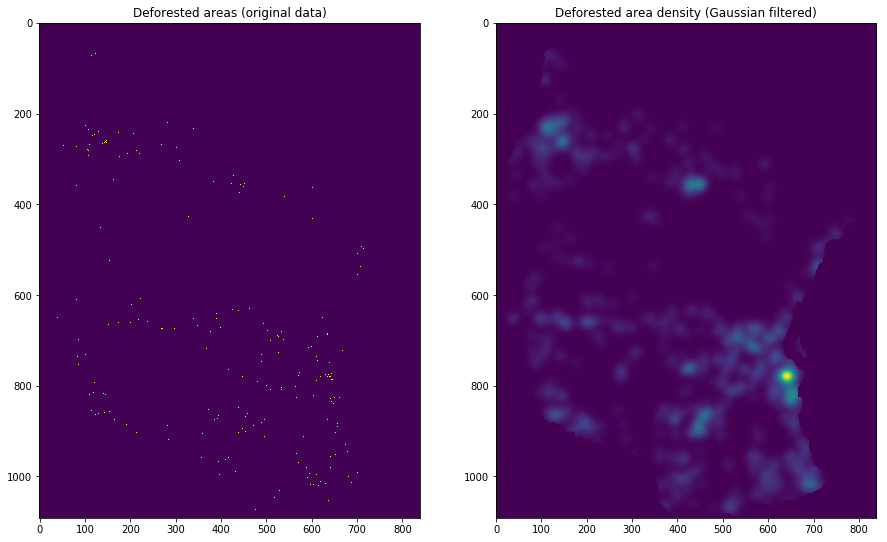

In [5]:
filter_scale = 10
loss_density = scipy.ndimage.filters.gaussian_filter(loss_in_year(10), filter_scale, mode='nearest') * extent

subplot(121)
title('Deforested areas (original data)')
imshow(loss_in_year(10))
subplot(122)
title('Deforested area density (Gaussian filtered)')
imshow(loss_density)
gcf().set_size_inches(15,10)

Now let's try the same thing for the data on road locations. By Gaussian filtering, we can get a measure of how dense the road network is in each place.

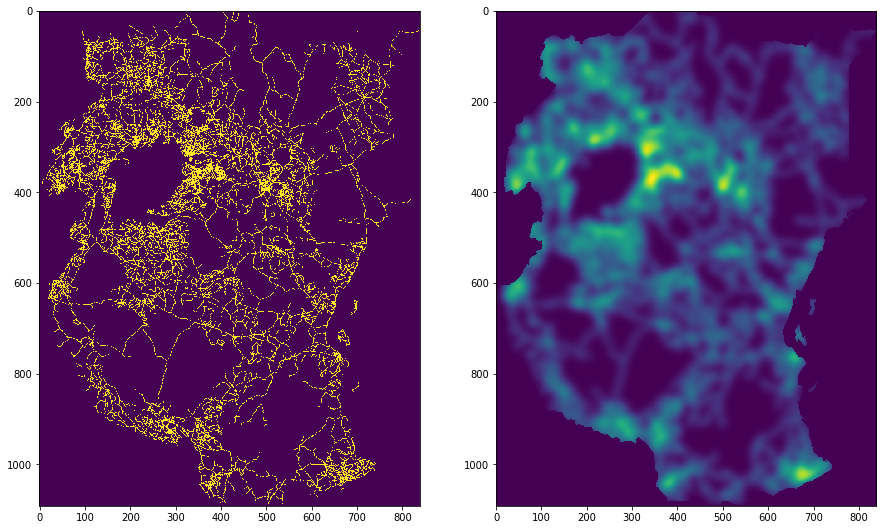

In [6]:
filter_scale = 10
roads_density = scipy.ndimage.filters.gaussian_filter(roads, filter_scale, mode='nearest') * extent

subplot(121)
imshow(roads)
subplot(122)
imshow(roads_density)
gcf().set_size_inches(15,10)

## Prediction of deforestation

Start by tring to predict based only on the deforestation locations in the previous year. 

We simply use the density of deforestation in the previous year at each location as the prediction of deforestation the following year. This is basically saying "we predict there will be deforestation anywhere that was nearby a lot of deforestation the year before."

Text(0.5,1,'ROC curve for prediction of deforestation in 2016')

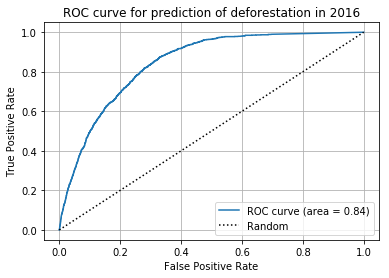

In [7]:
target_year = 16

# Which are the pixels inside the region of interest?
idx1,idx2 = np.where(extent)

# We want to predict the loss in the target year
y_test = loss_in_year(target_year)[idx1,idx2]

# Start with predictions which is simply the smoothed forest loss from the previous year
loss_density = scipy.ndimage.filters.gaussian_filter(loss_in_year(target_year-1), 11, mode='nearest') * extent
y_pred = loss_density[idx1,idx2]

# Evaluate these predictions
fpr,tpr,thresholds = metrics.roc_curve(y_test,y_pred)
roc_auc = metrics.roc_auc_score(y_test,y_pred)

# Plot the results
plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
               ''.format(roc_auc))

plt.plot([0,1],[0,1],'k:',label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.title('ROC curve for prediction of deforestation in {}'.format(2000+target_year))

The area under the ROC curve is actually not too bad even with this simple prediction! But let's see if we can do better by bringing in other types of information...

# Prediction with covariates

Now try the prediction with some other covariates: we will bring in information about road density, protected area status, forest cover. This involves training a classifier where:

- The features X are the density of deforestation in previous year, density of roads, protected area status, tree cover level in previous year, for a particular location.
- The target variable y is 0 or 1 depending on whether that location was deforested or not.

We use a gradient boosting classifier here, but lots of other types of classifiers could also be tried.

In [8]:
target_year = 15

# Which are the pixels inside the region of interest?
idx1,idx2 = np.where(extent)

# We want to predict the loss in the target year
y_train = loss_in_year(target_year)[idx1,idx2]

# Calculate some more covariates
loss_density = 0*scipy.ndimage.filters.gaussian_filter(loss_in_year(target_year-1), 11, mode='nearest') * extent
road_density = scipy.ndimage.filters.gaussian_filter(roads, 7, mode='nearest') * extent

X_train = np.vstack((loss_density[idx1,idx2],
                     road_density[idx1,idx2],
                     protectedareas[idx1,idx2],
                     treecover_at_year(target_year-1)[idx1,idx2])).transpose()

clf = ensemble.GradientBoostingClassifier()
%time clf.fit(X_train,y_train)

CPU times: user 24.2 s, sys: 335 ms, total: 24.5 s
Wall time: 24.5 s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

Now that the classifier has been trained, evaluate it with data from a different year.

Text(0.5,1,'ROC curve for prediction of deforestation in 2016')

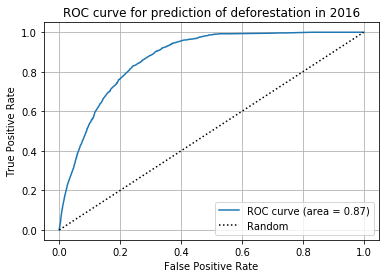

In [9]:
target_year = 16

loss_density = scipy.ndimage.filters.gaussian_filter(loss_in_year(target_year-1), 11, mode='nearest') * extent

X_test = np.vstack((loss_density[idx1,idx2],
                    road_density[idx1,idx2],
                    protectedareas[idx1,idx2],
                    treecover_at_year(target_year-1)[idx1,idx2])).transpose()

y_pred = clf.predict_proba(X_test)[:,1]

y_test = loss_in_year(target_year)[idx1,idx2]

# Evaluate these predictions
fpr,tpr,thresholds = metrics.roc_curve(y_test,y_pred)
roc_auc = metrics.roc_auc_score(y_test,y_pred)

# Plot the results
plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
               ''.format(roc_auc))

plt.plot([0,1],[0,1],'k:',label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.title('ROC curve for prediction of deforestation in {}'.format(2000+target_year))

# View the deforestation forecast

Use the trained classifier to make predictions at all locations, and plot the result.

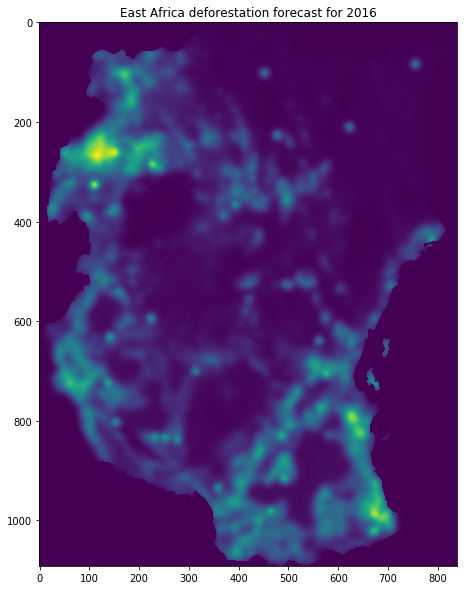

In [10]:
year = 2016

loss_density = scipy.ndimage.filters.gaussian_filter(loss_in_year(year-2000), 11, mode='nearest') * extent

X_test = np.vstack((loss_density[idx1,idx2],
                    road_density[idx1,idx2],
                    protectedareas[idx1,idx2],
                    treecover_at_year(target_year-1)[idx1,idx2])).transpose()

y_pred = clf.predict_proba(X_test)[:,1]

prediction = np.zeros(extent.shape)
prediction[idx1,idx2] = y_pred

# For visualisation, smooth out the points a bit to make it easier to see
prediction_smoothed = scipy.ndimage.filters.gaussian_filter(prediction, 7, mode='nearest') * extent
imshow(prediction_smoothed)
title('East Africa deforestation forecast for %d' % (year))
gcf().set_size_inches(10,10)

If you have the gdal library installed, then the predictions can be written to a GeoTIFF (for viewing in QGIS, Google Earth, or other software). Viewing in GIS software allows you to align this forecast on a map, and to zoom in, etc. 

*Note: Sometimes installing the gdal library is tricky, so don't worry if this doesn't work; this step is only if you want to export a file for viewing the deforestation forecast on a map.*

In [11]:
import gdal
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(
    'data/deforestation_forecast.tif',
    prediction_smoothed.shape[1],
    prediction_smoothed.shape[0],
    1,
    gdal.GDT_Float32)
dataset.SetGeoTransform(geotransform)
band = dataset.GetRasterBand(1)
band.WriteArray(prediction_smoothed)
band.SetNoDataValue(0)
dataset.FlushCache()
dataset = None

## Exercises

- Calculate the overall forest loss in Kenya, Tanzania and Uganda from 2000-2016. Is deforestation increasing or reducing?
- Can you alter the model, using any methods for regression you know, to get more accurate predictions?
- Find the areas with the highest deforestation risk this year, and use XY2lonlat() to get their locations. Where are they?

## Further information

For a more in depth model of spatiotemporal prediction, see the documentation of the R Spatiotemporal package:<br>
https://cran.r-project.org/web/packages/SpatioTemporal/vignettes/ST_intro.pdf

## More data

EUMeteoStat, hourly weather satellite data<br>
http://oiswww.eumetsat.org/IPPS/html/MSGIODC/RGB/NATURALCOLOR/CENTRALAFRICA/index.htm

Africa remote sensing data, including rainfall and vegetation strength<br>
https://earlywarning.usgs.gov/fews/search/Africa